In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

from mpl_toolkits.mplot3d import Axes3D

In [2]:
import tensorflow

In [3]:
raw_data = pd.read_csv('DNEdited_weekly_rigs_and_oil_price.csv')
data = raw_data[::-1]

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
data.set_index('Date',inplace = True)
data.index

DatetimeIndex(['1987-07-17', '1987-07-24', '1987-07-31', '1987-08-07',
               '1987-08-14', '1987-08-21', '1987-08-28', '1987-09-04',
               '1987-09-11', '1987-09-18',
               ...
               '2020-06-26', '2020-07-03', '2020-07-10', '2020-07-17',
               '2020-07-24', '2020-07-31', '2020-08-07', '2020-08-14',
               '2020-08-21', '2020-08-28'],
              dtype='datetime64[ns]', name='Date', length=1729, freq=None)

In [6]:
train = data.iloc[-320:-20,2]
test = data.iloc[-20:,2]
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# train.set_index('Brent_Oil_Price','WTI_Oil_Price',inplace = True)
# test.set_index('Brent_Oil_Price','WTI_Oil_Price',inplace = True)

In [7]:
train.index

DatetimeIndex(['2014-07-18', '2014-07-25', '2014-08-01', '2014-08-08',
               '2014-08-15', '2014-08-22', '2014-08-29', '2014-09-05',
               '2014-09-12', '2014-09-19',
               ...
               '2020-02-07', '2020-02-14', '2020-02-21', '2020-02-28',
               '2020-03-06', '2020-03-13', '2020-03-20', '2020-03-27',
               '2020-04-03', '2020-04-10'],
              dtype='datetime64[ns]', name='Date', length=300, freq=None)

In [8]:
#Axes3D.scatter(d_price_WTI, d_rigs, zs=0, zdir='z', s=20, c=None, depthshade=True)

# d_time = data['Date'] #time
# d_rigs = data['Rigs_Count'] #rigs count column, y, index: 0
# d_price_WTI = data['WTI_Oil_Price'] #price column, x, index: 1
# d_price_Brent

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
#scaler only takes dataframe intead of series

In [10]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator #what is this

Using TensorFlow backend.


In [13]:
# define generator, equally spaced data rows
n_input = 30
n_features = 1
#batch size too large will overfit
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
for idx in range(len(generator)):
    X,y = generator[idx]
    print(f'Given the Array: \n{X.flatten()}')
    print(f'Predict this y: \n {y}')

Given the Array: 
[0.96070727 0.96856582 0.97249509 0.98493779 0.98821218 0.97707924
 0.98886706 0.99607073 1.         1.         1.         0.99410609
 0.99934512 0.99148657 0.99738048 0.99869024 0.99607073 0.99803536
 0.99869024 0.9908317  0.99279633 0.9751146  0.96332678 0.94040602
 0.92141454 0.88146693 0.83300589 0.8048461  0.74590701 0.68893255]
Predict this y: 
 [[0.62475442]]
Given the Array: 
[0.96856582 0.97249509 0.98493779 0.98821218 0.97707924 0.98886706
 0.99607073 1.         1.         1.         0.99410609 0.99934512
 0.99148657 0.99738048 0.99869024 0.99607073 0.99803536 0.99869024
 0.9908317  0.99279633 0.9751146  0.96332678 0.94040602 0.92141454
 0.88146693 0.83300589 0.8048461  0.74590701 0.68893255 0.62475442]
Predict this y: 
 [[0.59332024]]
Given the Array: 
[0.97249509 0.98493779 0.98821218 0.97707924 0.98886706 0.99607073
 1.         1.         1.         0.99410609 0.99934512 0.99148657
 0.99738048 0.99869024 0.99607073 0.99803536 0.99869024 0.9908317
 0.99279

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [16]:
n_input = 30
n_features = 1
#batch size too large will overfit
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences = True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))

#model.add(LSTM(150, return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(6,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(6))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 6)             1704      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 6)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [19]:
model.fit_generator(train_generator,epochs=40)


Epoch 1/40
270/270 [==============================] - 6s 21ms/step - loss: 0.0914
Epoch 2/40
270/270 [==============================] - 5s 18ms/step - loss: 0.0769
Epoch 3/40
270/270 [==============================] - 5s 18ms/step - loss: 0.0714
Epoch 4/40
270/270 [==============================] - 5s 18ms/step - loss: 0.0578
Epoch 5/40
270/270 [==============================] - 6s 21ms/step - loss: 0.0488
Epoch 6/40
270/270 [==============================] - 6s 20ms/step - loss: 0.0490
Epoch 7/40
270/270 [==============================] - 5s 20ms/step - loss: 0.0453
Epoch 8/40
270/270 [==============================] - 5s 20ms/step - loss: 0.0426
Epoch 9/40
270/270 [==============================] - 5s 20ms/step - loss: 0.0388
Epoch 10/40
270/270 [==============================] - 5s 19ms/step - loss: 0.0346: 0s
Epoch 11/40
270/270 [==============================] - 5s 18ms/step - loss: 0.0369
Epoch 12/40
270/270 [==============================] - 5s 18ms/step - loss: 0.0318
Epoch 13

In [ ]:
model.history.history.keys()

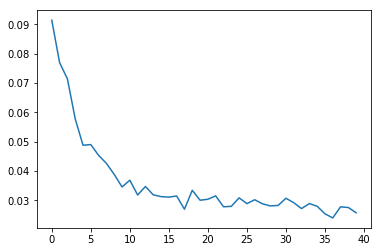

In [20]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
from keras import backend as K 
K.clear_session()

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(loss_per_epoch[5:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [21]:
# 16 history steps --> step 17
# last 16 points in train --> pt 1 in test data
first_eval_batch = scaled_train[-n_input:]

In [22]:
first_eval_batch

array([[0.30386379],
       [0.29862475],
       [0.29535036],
       [0.29600524],
       [0.29273084],
       [0.27897839],
       [0.27373936],
       [0.27046496],
       [0.2632613 ],
       [0.26129666],
       [0.26064178],
       [0.25867714],
       [0.25867714],
       [0.26784545],
       [0.26260642],
       [0.25671251],
       [0.24688933],
       [0.25671251],
       [0.25540275],
       [0.25278324],
       [0.25278324],
       [0.25278324],
       [0.25343811],
       [0.25278324],
       [0.25474787],
       [0.25409299],
       [0.24099542],
       [0.21218075],
       [0.1702685 ],
       [0.12966601]])

In [23]:
scaled_test

array([[ 0.08185986],
       [ 0.03994761],
       [ 0.00261952],
       [-0.01964637],
       [-0.04256713],
       [-0.05631958],
       [-0.06745252],
       [-0.07858546],
       [-0.08185986],
       [-0.09037328],
       [-0.09102816],
       [-0.09233792],
       [-0.09561231],
       [-0.09888671],
       [-0.10019646],
       [-0.10019646],
       [-0.10281598],
       [-0.10478062],
       [-0.09823183],
       [-0.09823183]])

In [ ]:
train.tail()

In [24]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))# make it 3 dimensional

In [25]:
model.predict(first_eval_batch)

array([[0.19494736]], dtype=float32)

In [26]:
scaled_test[0]

array([0.08185986])

In [27]:
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants(same format as TimeSeries Generator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

#how far into the future will I forecast?
#len(test) -->I can also change to 24

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
scaled_test

In [28]:
mean_absolute_error(scaled_test,test_predictions)

0.10267964897929802

In [29]:
true_predictions = scaler.inverse_transform(test_predictions)

In [30]:
true_test = scaler.inverse_transform(scaled_test)

In [ ]:
true_test

In [31]:
test['Predictions'] = true_predictions

In [32]:
mean_absolute_error(test['Rigs_Count'],test['Predictions'])

156.79182399138807

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
test_2 = test.reset_index()
ax.scatter(test_2['WTI_Oil_Price'], test_2['Rigs_Count'], color='r',label = "Actual Rigs Count")
ax.scatter(test_2['WTI_Oil_Price'], test_2['Predictions'], color='b', label = "Predictions")
ax.set_xlabel('WTI Oil Price')
ax.set_ylabel('Rigs Count')
ax.set_title('scatter plot')
plt.legend()
plt.show()

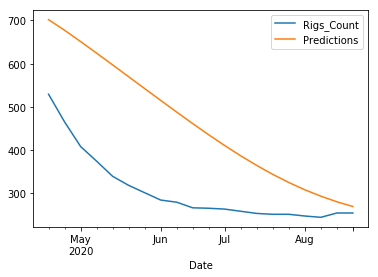

In [33]:
test.plot()